# Importazione librerie

In [310]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lettura dati Bitcoin

In [311]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [312]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
data_inizio = '2021-05-01'
data_fine = '2021-07-31'

# Periodo personale
# data_inizio = '2020-02-29'
# data_fine = '2021-12-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-05-01,48110.046875
1,2021-05-02,47088.570312
2,2021-05-03,47432.769531
3,2021-05-04,44387.261719
4,2021-05-05,47823.058594
...,...,...
87,2021-07-27,33336.066406
88,2021-07-28,33764.222656
89,2021-07-29,33643.082031
90,2021-07-30,35590.078125


In [313]:
dati_da_usare = []

path = r'100_datasets_60_days_random_state_8_period_9_jan_2021_3_dic_2023.csv'
df = pd.read_csv(path)
for col in df.columns[1:]:  # Escludi la prima colonna 'Timestamp'
        temp_df = df[['Timestamp', col]].copy()
        temp_df.rename(columns={col: 'Price'}, inplace=True)
        dati_da_usare.append(temp_df)


dati = dati_da_usare[13]
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])

In [314]:
dati

,Timestamp,Price
0,2021-01-09,26831.294922
1,2021-01-10,26847.951172
2,2021-01-11,26758.697266
3,2021-01-12,26960.865234
4,2021-01-13,26752.154297
5,2021-01-14,26393.152344
6,2021-01-15,24520.585938
7,2021-01-16,23921.724609
8,2021-01-17,23964.562500
9,2021-01-18,24081.244141


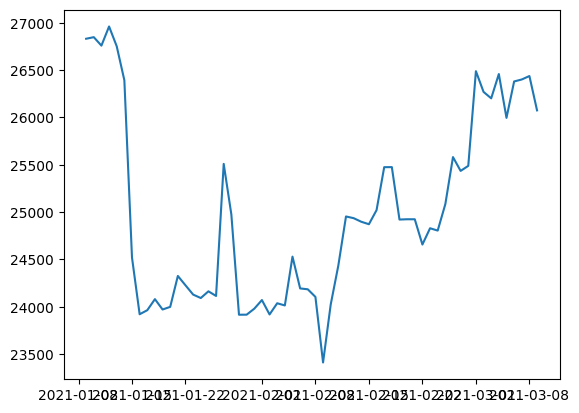

In [315]:
plt.plot(dati['Timestamp'], dati['Price'])

In [316]:
def calcola_rendimento_portafoglio_ideale(lista_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi.iloc[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

# Strategia

In [317]:
# Funzione helper per calcolare quanto acquistare
def quanto_acquistare(A_a, B_a, variazione_perc, liquidità_attuale, max_liquidità, spesa_primo_acquisto):
    return min(
        spesa_primo_acquisto + max_liquidità * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a),
        liquidità_attuale
    )

# Funzione helper per calcolare quanto vendere
def quanto_vendere(A_v, B_v, variazione_vendite_inversa, bitcoin, max_bitcoin, bitcoin_venduti_prima_vendita):
    return min(
        bitcoin_venduti_prima_vendita + max_bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v),
        bitcoin
    )

# Funzione per calcolare la variazione percentuale per gli acquisti
def calcola_variazione_percentuale(prezzo_attuale, prezzo_riferimento):
    return (prezzo_attuale - prezzo_riferimento) / prezzo_riferimento

# Funzione per calcolare la variazione percentuale inversa per le vendite
def calcola_variazione_percentuale_inversa(prezzo_prima_vendita, prezzo_attuale):
    return (prezzo_prima_vendita - prezzo_attuale) / prezzo_attuale

# Funzione principale della strategia
def trading_semplificato(dati, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita, 
                      liquidità_iniziale, bitcoin_iniziali, perc_primo_acquisto, perc_prima_vendita, 
                      A_a, B_a, A_v, B_v, compra_solo_sotto_ultimo, vendi_sopra_spesa_totale):
    # Stato iniziale
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_medio_pesato_acquisti = None
    prezzo_medio_pesato_vendite = None
    spesa_totale_acquisti = 0
    guadagno_totale_vendite_euro = 0
    max_liquidità = liquidità
    max_bitcoin = bitcoin
    prezzo_prima_vendita = None
    prezzo_primo_acquisto = None
    prezzo_ultimo_acquisto = None
    transazioni = []  # Registro delle transazioni

    # Flag per identificare l'inizio di un nuovo ciclo
    nuovo_ciclo = True

    for i, row in dati.iterrows():
        timestamp = row['Timestamp']
        prezzo = row['Price']
        azione = '-'  # azione di default

        # Reset ciclo se necessario
        if i > 0 and prezzo < dati.iloc[i - 1]['Price'] and prezzo_prima_vendita is not None or i==0:
            nuovo_ciclo = True
            prezzo_medio_pesato_acquisti = None
            prezzo_medio_pesato_vendite = None
            prezzo_prima_vendita = None
            spesa_totale_acquisti = 0
            guadagno_totale_vendite_euro = 0
            max_liquidità = liquidità
            max_bitcoin = bitcoin
        else:
            nuovo_ciclo = False

        # Primo acquisto di un ciclo
        if nuovo_ciclo:
            spesa = liquidità * perc_primo_acquisto
            if spesa > 0 and spesa >= min_acquisto:
                commissione = spesa * perc_commissione_acquisto / prezzo # Commissione in bitcoin
                bitcoin_acquistati = spesa / prezzo - commissione
                liquidità -= spesa
                bitcoin += bitcoin_acquistati
                prezzo_primo_acquisto = prezzo
                prezzo_ultimo_acquisto = prezzo
                prezzo_medio_pesato_acquisti = prezzo
                spesa_totale_acquisti = spesa
                max_liquidità = max(max_liquidità, liquidità)
                max_bitcoin = max(max_bitcoin, bitcoin)
                spesa_primo_acquisto = spesa
                azione = 'Primo acquisto'
            transazioni.append([
                timestamp, prezzo, azione, bitcoin_acquistati, spesa, spesa_totale_acquisti, liquidità, bitcoin, max_liquidità, max_bitcoin,
                prezzo_medio_pesato_acquisti, prezzo_medio_pesato_vendite, bitcoin*prezzo+liquidità
            ])
            continue
        # Calcola variazione percentuale rispetto al primo acquisto del ciclo
        variazione_perc = calcola_variazione_percentuale(prezzo, prezzo_primo_acquisto)

        # Scenario 1: prezzo < prezzo medio pesato di acquisto
        if prezzo <= prezzo_medio_pesato_acquisti:
            if (compra_solo_sotto_ultimo and prezzo < prezzo_ultimo_acquisto) or not compra_solo_sotto_ultimo:
                spesa = quanto_acquistare(A_a, B_a, variazione_perc, liquidità, max_liquidità, spesa_primo_acquisto)
                if spesa > 0 and spesa >= min_acquisto:
                    commissione = spesa * perc_commissione_acquisto / prezzo # Commissione in bitcoin
                    bitcoin_acquistati = spesa / prezzo - commissione
                    liquidità -= spesa
                    bitcoin += bitcoin_acquistati
                    spesa_totale_acquisti += spesa
                    prezzo_medio_pesato_acquisti = (
                        (prezzo_medio_pesato_acquisti * (spesa_totale_acquisti - spesa) + prezzo * spesa) /
                        spesa_totale_acquisti
                    )
                    prezzo_ultimo_acquisto = prezzo
                    azione = 'Acquisto'

        # Scenario 2: prezzo > prezzo medio pesato di acquisto
        elif prezzo > prezzo_medio_pesato_acquisti:
            if prezzo_medio_pesato_vendite is None:  # Prima vendita del ciclo
                vendita = bitcoin * perc_prima_vendita
                if vendita > 0 and vendita >= min_vendita / prezzo and (not vendi_sopra_spesa_totale or vendi_sopra_spesa_totale and vendita * prezzo * (1 - perc_commissione_vendita) > spesa_totale_acquisti):
                    vendita_euro = vendita * prezzo
                    commissione = vendita_euro * perc_commissione_vendita # Commissione in euro
                    guadagno = vendita_euro - commissione
                    liquidità += guadagno
                    bitcoin -= vendita
                    prezzo_prima_vendita = prezzo
                    prezzo_medio_pesato_vendite = prezzo
                    guadagno_totale_vendite_euro = guadagno
                    bitcoin_venduti_prima_vendita = vendita
                    azione = 'Vendita'
            else:
                variazione_vendite_inversa = calcola_variazione_percentuale_inversa(prezzo_prima_vendita, prezzo)
                vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, bitcoin, max_bitcoin, bitcoin_venduti_prima_vendita)
                if vendita > 0 and vendita >= min_vendita / prezzo and (not vendi_sopra_spesa_totale or vendi_sopra_spesa_totale and vendita * prezzo * (1 - perc_commissione_vendita) > spesa_totale_acquisti):
                    vendita_euro = vendita * prezzo
                    commissione = vendita_euro * perc_commissione_vendita  # Commissione in euro
                    guadagno = vendita_euro - commissione
                    liquidità += guadagno
                    bitcoin -= vendita
                    guadagno_totale_vendite_euro += guadagno
                    prezzo_medio_pesato_vendite = (
                        (prezzo_medio_pesato_vendite * (guadagno_totale_vendite_euro - vendita_euro) + prezzo * vendita_euro) /
                        guadagno_totale_vendite_euro
                    )
                    azione = 'Vendita'

        # Aggiorna stato massimo
        max_liquidità = max(max_liquidità, liquidità)
        max_bitcoin = max(max_bitcoin, bitcoin)
        bitcoin_comprati_o_venduti = bitcoin_acquistati if azione=='Acquisto' else vendita if azione=='Vendita' else 0
        liquidità_spesa_o_guadagnata = spesa if azione=='Acquisto' else guadagno if azione=='Vendita' else 0

        # Registra l'azione del giorno
        transazioni.append([
            timestamp, prezzo, azione, bitcoin_comprati_o_venduti, liquidità_spesa_o_guadagnata, spesa_totale_acquisti, liquidità, bitcoin, max_liquidità, max_bitcoin,
            prezzo_medio_pesato_acquisti, prezzo_medio_pesato_vendite, bitcoin*prezzo+liquidità
        ])

    # Ritorna il dataframe delle transazioni
    return pd.DataFrame(transazioni, columns=[
        'timestamp', 'prezzo', 'azione', 'bitcoin_comprati_o_venduti', 'liquidità_spesa_o_guadagnata', 'spesa_totale_acquisti', 'liquidità', 'bitcoin', 
        'Max liquidità', 'Max bitcoin', 'prezzo Medio Pesato Acquisto', 'prezzo Medio Pesato Vendita', 'valore_totale_portafoglio'
    ])

In [318]:
min_acquisto = 1
min_vendita = 1
perc_commissione_acquisto = 0.001
perc_commissione_vendita = 0.001
liquidità_iniziale = 1000
bitcoin_iniziali = 0
perc_primo_acquisto = 0.5
perc_prima_vendita = 1
A_a = 0.01
B_a = 0.001
A_v = 0.01
B_v = 0.001
compra_solo_sotto_ultimo = True
vendi_sopra_spesa_totale = True

df_transazioni = trading_semplificato(dati, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita, liquidità_iniziale, bitcoin_iniziali, perc_primo_acquisto, perc_prima_vendita, A_a, B_a, A_v, B_v, compra_solo_sotto_ultimo, vendi_sopra_spesa_totale)
df_transazioni

,timestamp,prezzo,azione,bitcoin_comprati_o_venduti,liquidità_spesa_o_guadagnata,spesa_totale_acquisti,liquidità,bitcoin,Max liquidità,Max bitcoin,prezzo Medio Pesato Acquisto,prezzo Medio Pesato Vendita,valore_totale_portafoglio
0,2021-01-09,26831.294922,Primo acquisto,0.018616,500.000000,500.000000,500.000000,0.018616,1000.000000,0.018616,26831.294922,NaN,999.500000
1,2021-01-10,26847.951172,-,0.000000,0.000000,500.000000,500.000000,0.018616,1000.000000,0.018616,26831.294922,NaN,999.810078
2,2021-01-11,26758.697266,Acquisto,0.018667,500.000000,1000.000000,0.000000,0.037283,1000.000000,0.037283,26794.996094,NaN,997.648499
3,2021-01-12,26960.865234,Vendita,0.037283,1004.180771,1000.000000,1004.180771,0.000000,1004.180771,0.037283,26794.996094,26960.865234,1004.180771
4,2021-01-13,26752.154297,Primo acquisto,0.018749,502.090386,502.090386,502.090386,0.018749,1004.180771,0.018749,26752.154297,NaN,1003.678681
5,2021-01-14,26393.152344,Acquisto,0.019004,502.090386,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,996.445500
6,2021-01-15,24520.585938,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,925.748739
7,2021-01-16,23921.724609,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,903.139364
8,2021-01-17,23964.562500,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,904.756664
9,2021-01-18,24081.244141,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,909.161855


In [319]:
# taglia_ad_ultima_vendita = True

# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0,
#     'min_acquisto': 1,
#     'min_vendita': 1,
#     'perc_commissione_acquisto': 0.001,
#     'perc_commissione_vendita': 0.001
# }
# if not df_transazioni[df_transazioni['azione'] == 'Vendita'].empty:
#     indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax()
#     if indice_ultima_vendita:
#         df_transazioni = df_transazioni.iloc[:indice_ultima_vendita + 1]
#         ideal_return = calcola_rendimento_portafoglio_ideale(df_transazioni['prezzo'].iloc[:indice_ultima_vendita + 1], *[parametri_fissi[chiave] for chiave in parametri_fissi.keys()])[0]

In [320]:
df_transazioni

,timestamp,prezzo,azione,bitcoin_comprati_o_venduti,liquidità_spesa_o_guadagnata,spesa_totale_acquisti,liquidità,bitcoin,Max liquidità,Max bitcoin,prezzo Medio Pesato Acquisto,prezzo Medio Pesato Vendita,valore_totale_portafoglio
0,2021-01-09,26831.294922,Primo acquisto,0.018616,500.000000,500.000000,500.000000,0.018616,1000.000000,0.018616,26831.294922,NaN,999.500000
1,2021-01-10,26847.951172,-,0.000000,0.000000,500.000000,500.000000,0.018616,1000.000000,0.018616,26831.294922,NaN,999.810078
2,2021-01-11,26758.697266,Acquisto,0.018667,500.000000,1000.000000,0.000000,0.037283,1000.000000,0.037283,26794.996094,NaN,997.648499
3,2021-01-12,26960.865234,Vendita,0.037283,1004.180771,1000.000000,1004.180771,0.000000,1004.180771,0.037283,26794.996094,26960.865234,1004.180771
4,2021-01-13,26752.154297,Primo acquisto,0.018749,502.090386,502.090386,502.090386,0.018749,1004.180771,0.018749,26752.154297,NaN,1003.678681
5,2021-01-14,26393.152344,Acquisto,0.019004,502.090386,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,996.445500
6,2021-01-15,24520.585938,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,925.748739
7,2021-01-16,23921.724609,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,903.139364
8,2021-01-17,23964.562500,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,904.756664
9,2021-01-18,24081.244141,-,0.000000,0.000000,1004.180771,0.000000,0.037754,1004.180771,0.037754,26572.653320,NaN,909.161855


In [321]:
df_transazioni[df_transazioni['azione'] == 'Primo acquisto']

,timestamp,prezzo,azione,bitcoin_comprati_o_venduti,liquidità_spesa_o_guadagnata,spesa_totale_acquisti,liquidità,bitcoin,Max liquidità,Max bitcoin,prezzo Medio Pesato Acquisto,prezzo Medio Pesato Vendita,valore_totale_portafoglio
0,2021-01-09,26831.294922,Primo acquisto,0.018616,500.000000,500.000000,500.000000,0.018616,1000.000000,0.018616,26831.294922,NaN,999.500000
4,2021-01-13,26752.154297,Primo acquisto,0.018749,502.090386,502.090386,502.090386,0.018749,1004.180771,0.018749,26752.154297,NaN,1003.678681


In [322]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.9849187857939153)

In [323]:
df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax()

np.int64(3)

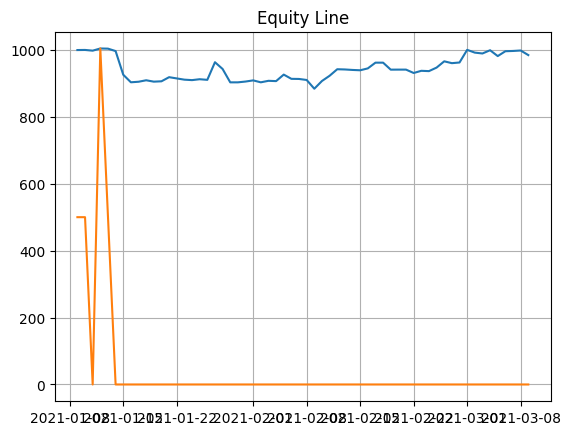

In [324]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio'])
plt.plot(df_transazioni['timestamp'], df_transazioni['liquidità'])

In [325]:
indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax()

rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(df_transazioni['prezzo'].iloc[:indice_ultima_vendita + 1], liquidità_iniziale, bitcoin_iniziali, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', round(portafoglio_finale_ideale, 6))

valore_iniziale = liquidità_iniziale + bitcoin_iniziali * df_transazioni['prezzo'].iloc[:indice_ultima_vendita + 1].iloc[0]
valore_finale = df_transazioni['valore_totale_portafoglio'].iloc[:indice_ultima_vendita + 1].iloc[-1]
rendimento = valore_finale / valore_iniziale

print(f"Rendimento del portafoglio: {round(rendimento, 6)}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 6)}%')
# print(f"Punteggio considerato sufficiente: {round(calcola_punteggio_sufficienza_medio([pd.DataFrame({'Price': df_transazioni['prezzo']})]) * 100, 2)}%")
print(f"Valore finale del portafoglio in euro: {round(df_transazioni['valore_totale_portafoglio'].iloc[:indice_ultima_vendita + 1].iloc[-1], 2)}")

Rendimento ideale: 1.0041540140002438
Portafoglio finale ideale in euro: 1004.154014
Rendimento del portafoglio: 1.004181
Punteggio rendimento: 100.002665%
Valore finale del portafoglio in euro: 1004.18


In [301]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [302]:
df_transazioni['prezzo'].iloc[3] / df_transazioni['prezzo'].iloc[2] * df_transazioni['prezzo'].iloc[1] / df_transazioni['prezzo'].iloc[0]

np.float64(1.008180691714667)

In [303]:
crea_grafico_transazioni(df_transazioni)